In [135]:
from vowpalwabbit import pyvw
import matplotlib.pyplot as plt
import pandas as pd
import random
import math

NUM_ITERATIONS = 250

# Reward function
The chosen action is supplied to the this to determine the reward. In reality the reward can also depends on the shared context, but for this simple example it does not.

In [136]:
def reward_function(color_index, font_index):
    color_values = [0.3, 0.5, 0.6, 0.2]
    font_values = [0.1, 0.4, 0.05]
    return color_values[color_index] + font_values[font_index]
    

# Slates

In [137]:
def generate_slates_text_format():
    return [
        "slates shared | location=US",
        "slates action 0 |Action black", 
        "slates action 0 |Action grey", 
        "slates action 0 |Action green", 
        "slates action 0 |Action yellow", 
        "slates action 1 |Action serif", 
        "slates action 1 |Action sans-serif", 
        "slates action 1 |Action comic-sans", 
        "slates slot |Slot color", 
        "slates slot |Slot font"
    ]

def generate_slates_text_format_with_label(reward, chosen_color_index, chosen_color_prob, chosen_font_index, chosen_font_prob):
    return [
        f"slates shared {-1*reward} | location=US",
        "slates action 0 |Action black", 
        "slates action 0 |Action grey", 
        "slates action 0 |Action green", 
        "slates action 0 |Action yellow", 
        "slates action 1 |Action serif", 
        "slates action 1 |Action sans-serif", 
        "slates action 1 |Action comic-sans",  
        f"slates slot {chosen_color_index}:{chosen_color_prob} |Slot color", 
        f"slates slot {chosen_font_index}:{chosen_font_prob} |Slot font"
    ]

In [138]:
slates_vw = pyvw.vw("--slates --epsilon 0.2 -q SA -l 0.05 --power_t 0")

slates_rewards = []
for _ in range(NUM_ITERATIONS):
    slates_prediction = slates_vw.predict(generate_slates_text_format())
    color_index, color_prob = slates_prediction[0][0]
    font_index, font_prob = slates_prediction[1][0]
    reward = reward_function(color_index, font_index)
    slates_rewards.append(reward)
    slates_vw.learn(generate_slates_text_format_with_label(reward, color_index, color_prob, font_index, font_prob))

slates_vw.finish()

# Contextual Bandit
This involves expanding out *all* possible combinations.

In [139]:
def generate_cb_text_format():
    return [
        "shared | location=US",
        "|Action color=black font=serif",
        "|Action color=grey font=serif",
        "|Action color=green font=serif",
        "|Action color=yellow font=serif",
        "|Action color=black font=sans-serif",
        "|Action color=grey font=sans-serif",
        "|Action color=green font=sans-serif",
        "|Action color=yellow font=sans-serif",
        "|Action color=black font=comic-sans",
        "|Action color=grey font=comic-sans",
        "|Action color=green font=comic-sans",
        "|Action color=yellow font=comic-sans",
    ]

def chosen_action_to_chosen_color_and_font(chosen_action_index):
    chosen_color = chosen_action_index % 4
    chosen_font = math.floor(chosen_action_index / 4 )
    return chosen_color, chosen_font
    
def generate_cb_text_format_with_label(reward, chosen_action_index, prob):
    action_list =  [
        "shared | location=US",
        "|Action color=black font=serif",
        "|Action color=grey font=serif",
        "|Action color=green font=serif",
        "|Action color=yellow font=serif",
        "|Action color=black font=sans-serif",
        "|Action color=grey font=sans-serif",
        "|Action color=green font=sans-serif",
        "|Action color=yellow font=sans-serif",
        "|Action color=black font=comic-sans",
        "|Action color=grey font=comic-sans",
        "|Action color=green font=comic-sans",
        "|Action color=yellow font=comic-sans",
    ]
        
    action_list[chosen_action_index + 1]= f"0:{-1*reward}:{prob} {action_list[chosen_action_index + 1]}"
    return action_list
        
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [140]:
cb_vw = pyvw.vw("--cb_explore_adf --epsilon 0.2 -q AA -l 0.05 --power_t 0")

cb_rewards = []
for _ in range(NUM_ITERATIONS):
    cb_prediction = cb_vw.predict(generate_cb_text_format())
    chosen_index, prob = sample_custom_pmf(cb_prediction)
    color_index, font_index  = chosen_action_to_chosen_color_and_font(chosen_index)
    reward = reward_function(color_index, font_index)
    cb_rewards.append(reward)
    cb_vw.learn(generate_cb_text_format_with_label(reward, chosen_index, prob))

cb_vw.finish()

# Comparison

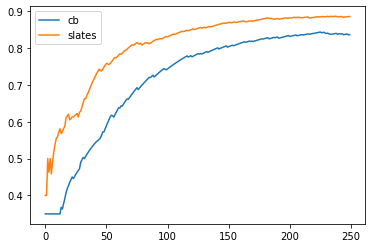

In [141]:
plt.plot(pd.Series(cb_rewards).expanding().mean())
plt.plot(pd.Series(slates_rewards).expanding().mean())
plt.legend(['cb', 'slates'])
